## 14-6. 프로젝트 : 폐렴 진단기 성능개선

### Step 1. 실험환경 Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 30

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 30

print(ROOT_PATH)

/home/aiffel-dj50/aiffel


#### 필요한 라이브러리들을 불러오고 학습 시켰던 기존 모델의 성능을 높여보고자 변수중 BATCH_SIZE는 16에서 30로 EPOCH는 25에서 30으로 변경한후 생성해 두었습니다.

### Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### 데이터를 불러와서 적은  val 갯수를 늘리고자  train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하였습니다.

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1069
Pneumonia images count in training set: 3116


#### 이미지 수를 출력해 보니 정상보다 폐렴 이미지 수가 3배 더 많이 있는  불균형(imbalance) 클래스 임을 확인할수 있습니다. 이것은 차후에 Weight balancing 적용해서 해결해 보려고 합니다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 tf.data 인스턴스를 만들었습니다.

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

#### 'NORMAL'과 'PNEUMONIA'이라는 라벨을 이용해서 라벨데이터를 만들어 주었습니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여주었습니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


#### train 데이터 셋과 validation 데이터 셋을 만들고, 이미지가 잘 리사이즈 된것을 확인할수 있습니다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### 좌우반전 augmentation를 도입하고 학습 데이터를 효율적으로 사용할수 있도록 데이터를 변환시켜 주었습니다.

### Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다. 

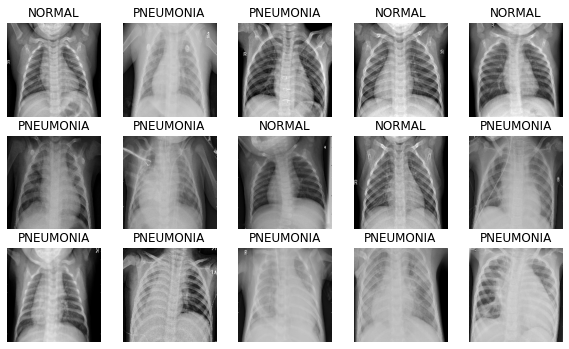

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

#### 데이터가 좌우로 잘 반전 된 것일까요? 봐도 잘 모르겠네요^^;;

### Step 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### CNN모델을 사용해 학습 시키겠습니다. 먼저 Convolution block을 구성하고, Dense Block은 Batch Normalization과 Dropout이라는 두가지 regularization 기법을 동시에 사용 하였습니다. 

### Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


#### imbalance를 해결하기 위해 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법인 Weight balancing을 사용했습니다. 

### Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
139/139 [==============================] - 31s 224ms/step - loss: 0.3901 - accuracy: 0.8082 - precision: 0.9525 - recall: 0.7812 - val_loss: 0.6682 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/30
139/139 [==============================] - 26s 190ms/step - loss: 0.2074 - accuracy: 0.9228 - precision: 0.9741 - recall: 0.9207 - val_loss: 0.9120 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/30
139/139 [==============================] - 26s 185ms/step - loss: 0.1752 - accuracy: 0.9350 - precision: 0.9790 - recall: 0.9327 - val_loss: 1.1959 - val_accuracy: 0.7382 - val_precision: 0.7382 - val_recall: 1.0000
Epoch 4/30
139/139 [==============================] - 25s 181ms/step - loss: 0.1645 - accuracy: 0.9436 - precision: 0.9809 - recall: 0.9428 - val_loss: 1.5052 - val_accuracy: 0.7343 - val_precision: 0.7343 - val_recall: 1.0000
Epoch 5/30
139/139 [==============================] - 26s 190ms/step - loss: 0.1515 - accura

#### 50 EPOCH로 훈련한 결과는 좋아 보이는데 시각화 하여 확인해 보겠습니다.

### Step 7. 결과 확인과 시각화

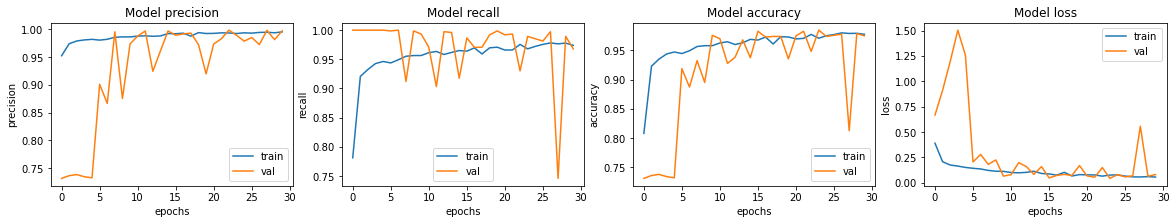

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 그래프를 출력하긴 했는데 정확하게 어떻게 분석해샤 하는지 잘 모르겠습니다. ㅜㅜ

In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

21/21 [==============================] - 25s 1s/step - loss: 0.7963 - accuracy: 0.8333 - precision: 0.8030 - recall: 0.9718


42/42 [==============================] - 18s 434ms/step - loss: 0.9520 - accuracy: 0.7821 - precision: 0.7510 - recall: 0.9744   

BATCH_SIZE: 15, EPOCHS: 50, regularization 기법 : Batch Normalization과 Dropout 두가지 사용

32/32 [==============================] - 2s 71ms/step - loss: 1.1648 - accuracy: 0.8013 - precision: 0.7639 - recall: 0.9872    


BATCH_SIZE: 20, EPOCHS: 30,  regularization 기법 :  Batch Normalization하나만

42/42 [==============================] - 16s 383ms/step - loss: 2.7418 - accuracy: 0.7179 - precision: 0.6890 - recall: 1.0000    

BATCH_SIZE: 15, EPOCHS: 50,  regularization 기법 :  Batch Normalization하나만

#### 몇번의 학습에도 85%의 성능은 나오지를 않네요 ㅜㅜ. 좀 더 여러가지의 파라미터를 바꿔보거나 다른  Data augmentation을 활용해 봐야 할듯 합니다.

## 총평

### 이번 과제를 하면서 의료현장에서 다루어지는 AI에 대한 관심이 높아졌습니다. 재미 있기도 하고 오히려 다른 데이터들보다 데이터가 복잡하거나 어렵지 않아서 데이터확보만 쉬워진다면 크게 성장할 가능성이 있는 분야인것 같습니다. 